In [1]:
import logging

import torch
import torch.optim as optim

from robustbench.data import load_cifar10c
from robustbench.model_zoo.enums import ThreatModel
from robustbench.utils import load_model
from nets import *

import time
import tent
import norm
import oracle
from utils import *
from matplotlib import pyplot as plt


import ipdb

from conf import cfg, load_cfg_fom_args, merge_from_file

corruption_list = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness',
                        'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [2]:
logger = logging.getLogger(__name__)
merge_from_file('cfgs/multistage.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(cfg)
print(device)

BN:
  EPS: 1e-05
  MOM: 0.1
CKPT_DIR: ./ckpt
CORRUPTION:
  DATASET: cifar10
  NUM_EX: 10000
  SEVERITY: [5]
  TYPE: ['gaussian_noise']
CUDNN:
  BENCHMARK: True
DATA_DIR: /gallery_tate/wonjae.roh
DESC: 
EPOCH: 50
EXPERIMENTAL:
  LINEAR_RETRAIN: False
ITERATION: 1
LOG_DEST: log.txt
LOG_TIME: 
MODEL:
  ADAPTATION: pl
  ARCH: RN18
  EPISODIC: False
OPTIM:
  BETA: 0.9
  DAMPENING: 0.0
  LR: 0.001
  METHOD: Adam
  MOMENTUM: 0.9
  NESTEROV: True
  STEPS: 10
  WD: 0.0
RNG_SEED: 1
SAVE_DIR: ./output
TEST:
  BATCH_SIZE: 200
cuda


### adaptation 없이 initial high_entropy samples, low_entropy samples index 찾기

In [3]:
def setup_tent(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    tent_model = tent.Tent(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return tent_model

def setup_pl(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    pl_model = tent.PL(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return pl_model

def setup_optimizer(params):
    """Set up optimizer for tent adaptation.

    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.

    For best results, try tuning the learning rate and batch size.
    """
    if cfg.OPTIM.METHOD == 'Adam':
        return optim.Adam(params,
                    lr=cfg.OPTIM.LR,
                    betas=(cfg.OPTIM.BETA, 0.999),
                    weight_decay=cfg.OPTIM.WD)
    elif cfg.OPTIM.METHOD == 'SGD':
        return optim.SGD(params,
                   lr=cfg.OPTIM.LR,
                   momentum=cfg.OPTIM.MOMENTUM,
                   dampening=cfg.OPTIM.DAMPENING,
                   weight_decay=cfg.OPTIM.WD,
                   nesterov=cfg.OPTIM.NESTEROV)
    else:
        raise NotImplementedError
    
def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    logger.info(f"model for evaluation: %s", model)
    return model

In [4]:

# configure model

if cfg.MODEL.ARCH == "Hendrycks2020AugMix_WRN":
    base_model = load_model(cfg.MODEL.ARCH, cfg.CKPT_DIR, cfg.CORRUPTION.DATASET, ThreatModel.corruptions).to(device)
elif cfg.MODEL.ARCH == "RN18":
    base_model = ResNet18(n_classes=10).to(device)
    ckpt = torch.load("/home2/wonjae.roh/nprc/tent/ckpt/cifar10/corruptions/ResNet18_pretrained.pth.tar", map_location=device)
    base_model.load_state_dict(ckpt["pretrain-learner"])
else:
    raise NotImplementedError


x_test, y_test = load_cifar10c(cfg.CORRUPTION.NUM_EX, cfg.CORRUPTION.SEVERITY[0], cfg.DATA_DIR, False, cfg.CORRUPTION.TYPE)
x_test, y_test = x_test.to(device), y_test.to(device)

acc, outputs = get_stats(base_model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True)



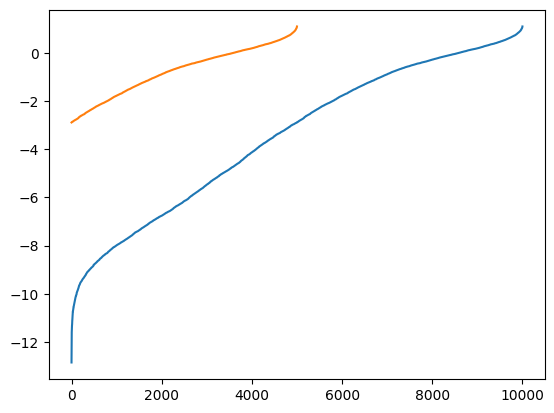

In [5]:
%matplotlib inline

entropy = tent.softmax_entropy(outputs)
entropy = torch.log2(entropy)
entropy_sorted, entropy_sorted_index = entropy.sort()
plt.plot(entropy_sorted.numpy())

high_index = entropy_sorted_index[5000:]
low_index = entropy_sorted_index[:5000]
high_values = entropy[high_index]
low_values = entropy[low_index]
plt.plot(high_values.numpy())

### Correct samples, Wrong samples entropy histogram visualize

                 0
count  6650.000000
mean     -4.490294
std       3.051585
min     -12.851542
25%      -7.051769
50%      -4.654666
75%      -1.754229
max       1.014241
                 0
count  3350.000000
mean     -1.380729
std       2.067541
min     -10.295473
25%      -2.323650
50%      -0.614420
75%       0.114202
max       1.095908


(array([  3.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   2.,
          2.,   2.,   3.,   2.,   2.,   1.,   4.,   3.,   2.,   2.,   5.,
          5.,   4.,   2.,   7.,   5.,   6.,   9.,   8.,  10.,   4.,   8.,
         11.,  13.,   9.,  11.,   6.,   8.,   9.,  13.,  12.,  11.,  13.,
         18.,  14.,  20.,  12.,  16.,  19.,  12.,  12.,  17.,  26.,  24.,
         15.,  25.,  19.,  25.,  24.,  27.,  29.,  27.,  28.,  42.,  32.,
         30.,  27.,  39.,  37.,  34.,  45.,  45.,  31.,  50.,  55.,  49.,
         52.,  57.,  69.,  50.,  71.,  63.,  76.,  91.,  93., 114., 124.,
        131., 157., 165., 170., 151., 150., 126.,  96.,  82.,  61.,  33.,
         20.]),
 array([-10.2954731 , -10.18155956, -10.06764507,  -9.95373154,
         -9.839818  ,  -9.72590446,  -9.61198997,  -9.49807644,
         -9.3841629 ,  -9.27024841,  -9.15633488,  -9.04242134,
         -8.9285078 ,  -8.81459332,  -8.70067978,  -8.58676624,
         -8.47285175,  -8.35893822,  -8.24502468,  -8.13111115

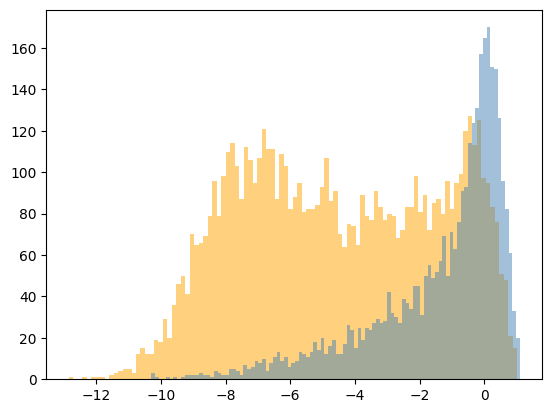

In [6]:
import pandas as pd

data_dir = "/gallery_tate/wonjae.roh/cifar10c"
labels_path = data_dir + '/labels.npy'
labels = np.load(labels_path)
# labels는 10000 sample, 5 severity에 대해 10000개의 같은 label이 5번 반복되는 형태이므로 잘라준다
labels = labels[:10000]

predicted = outputs.argmax(axis=1).numpy()

correct = predicted==labels
wrong = ~correct
entropy_numpy = entropy.numpy()

correct_entropy = entropy_numpy[correct]
wrong_entropy = entropy_numpy[wrong]

correct_describe = pd.DataFrame(correct_entropy)
print(correct_describe.describe())
wrong_describe = pd.DataFrame(wrong_entropy)
print(wrong_describe.describe())

plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [7]:
threshold = entropy_sorted[5000].item()
print(f'threshold : {threshold:.4f}') 

correct_high = np.sum(correct_describe > threshold)
correct_low = np.sum(correct_describe < threshold)
wrong_high = np.sum(wrong_describe > threshold)
wrong_low = np.sum(wrong_describe < threshold)

low_error = 100-float(correct_low * 100 / (correct_low + wrong_low))
high_error = 100-float(correct_high * 100 / (correct_high + wrong_high))
total_error = (low_error + high_error) / 2
                       
print(f'low_error : {low_error:.2f}')
print(f'high_error : {high_error:.2f}') 
print(f'total_error : {total_error:.2f}') 

threshold : -2.8889
low_error : 13.48
high_error : 53.51
total_error : 33.50


### Dataloader (low_entropy, high_entropy, all)

In [8]:
def get_subset(x, y, indices, shuffle=False):
    """get subset of data from indices
    Args:
    x: data
    y: labels
    indices: indices to get subset
    Returns:
    subset of data and labels
    """
    x_sub = x[indices]
    y_sub = y[indices]

    if shuffle:
        rand_idx = np.random.permutation(np.arange(len(x_sub)))
        x_sub, y_sub = x_sub[rand_idx], y_sub[rand_idx]

    return x_sub, y_sub
        
x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)     

### adaptation with suitable dataset (all)

In [9]:
def vis_entropy_histogram(outputs, labels):
    entropy = tent.softmax_entropy(outputs)
    entropy = torch.log2(entropy)
    entropy_numpy = entropy.numpy()
    labels = labels.cpu().numpy()

    predicted = outputs.argmax(axis=1).numpy()

    correct = predicted==labels
    wrong = ~correct

    correct_entropy = entropy_numpy[correct]
    wrong_entropy = entropy_numpy[wrong]


    correct_describe = pd.DataFrame(correct_entropy)
    print(correct_describe.describe())
    wrong_describe = pd.DataFrame(wrong_entropy)
    print(wrong_describe.describe())

    plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
    plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [10]:
if cfg.MODEL.ADAPTATION == "tent":
    logger.info("test-time adaptation: TENT")
    model = setup_tent(base_model)
elif cfg.MODEL.ADAPTATION == "source":
    logger.info("test-time adaptation: SOURCE")
    model = setup_source(base_model)
elif cfg.MODEL.ADAPTATION == "pl":
    logger.info("test-time adaptation: PL")
    model = setup_pl(base_model)

In [11]:
model.reset()

# check if it only prints desirable updating parameters
check_freeze(model.model)
 

bn1.weight
bn1.bias
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.shortcut.1.weight
layer2.0.shortcut.1.bias
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.shortcut.1.weight
layer3.0.shortcut.1.bias
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.shortcut.1.weight
layer4.0.shortcut.1.bias
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.bn2.weight
layer4.1.bn2.bias


total_error : 42.95
191s


(array([ 569.,  919.,  598., 1225.,  667., 1793., 1191.,  754.,  659.,
        1625.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe916b8e610>])

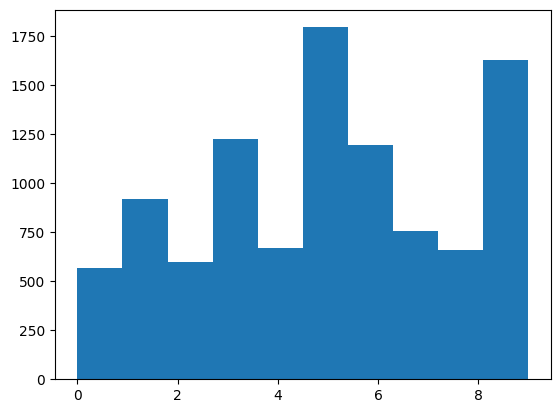

In [12]:
# adapt on all entropy samples
start=time.time()
acc_total, outputs_total = get_stats(model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
end=time.time()
print(f'total_error : {(1-acc_total)*100:.2f}') 
print(f'{end - start:.0f}s')

plt.hist(outputs_total.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

### adaptation with suitable dataset (low)

low_error : 14.16
high_error : 47.68
total_error : 30.92
99s


(array([563., 540., 318., 399., 412., 465., 582., 606., 563., 552.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe9169a5cd0>])

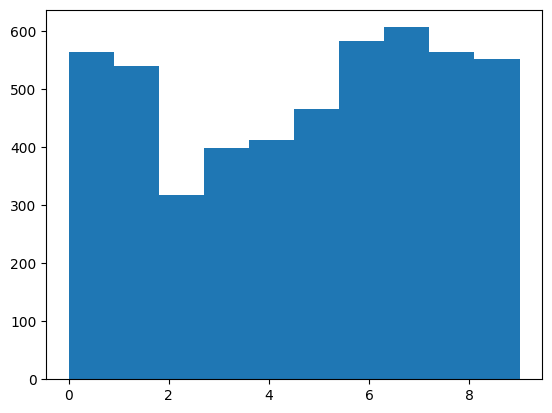

In [13]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
start=time.time()
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'low_error : {(1-acc_low)*100:.2f}')  

# without updating, check on high entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

end=time.time()
print(f'{end - start:.0f}s')

plt.hist(outputs_low.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')


                 0
count  4292.000000
mean     -8.757432
std       2.651088
min     -20.455881
25%     -10.590899
50%      -8.602511
75%      -6.721661
max      -2.792904
                0
count  708.000000
mean    -7.257043
std      2.404300
min    -18.215561
25%     -8.774784
50%     -6.796904
75%     -5.401281
max     -2.893661


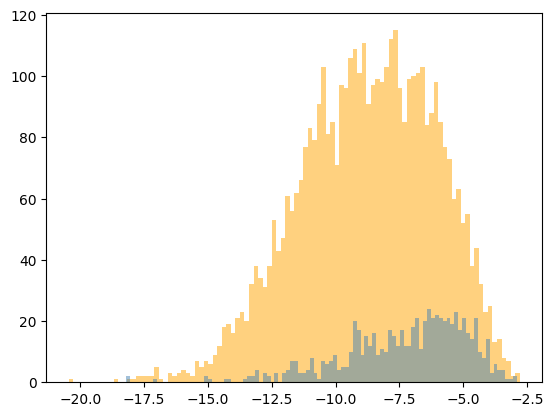

In [14]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  2616.000000
mean     -6.695228
std       4.714921
min     -22.926329
25%     -10.586086
50%      -6.392102
75%      -2.325490
max       0.858609
                 0
count  2384.000000
mean     -3.628889
std       3.908749
min     -19.890625
25%      -5.570357
50%      -2.209463
75%      -0.599448
max       0.776350


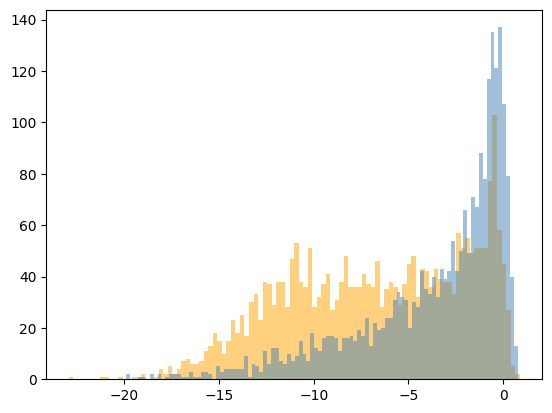

In [15]:
vis_entropy_histogram(outputs_high, y_high)

### adaptation with suitable dataset (high)

low_error : 22.32
high_error : 46.44
total_error : 34.38


(array([434., 506., 472., 853., 537., 405., 599., 292., 583., 319.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe9169cd7c0>])

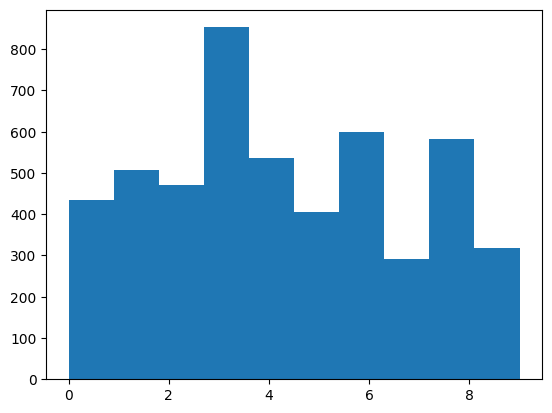

In [16]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)

# without updating, check on high entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'low_error : {(1-acc_low)*100:.2f}')  
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

plt.hist(outputs_high.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

                 0
count  3884.000000
mean    -10.043921
std       4.810384
min     -22.509657
25%     -13.589528
50%     -11.040770
75%      -6.727956
max       0.694122
                 0
count  1116.000000
mean     -5.058460
std       4.740119
min     -19.362911
25%      -8.045224
50%      -3.483136
75%      -1.050195
max       0.716410


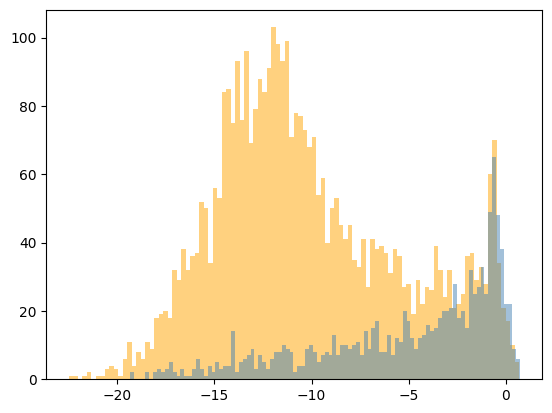

In [17]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  2678.000000
mean     -6.665545
std       3.515684
min     -18.549347
25%      -8.959073
50%      -5.701604
75%      -3.857205
max      -1.017254
                 0
count  2322.000000
mean     -4.856793
std       2.539339
min     -18.612555
25%      -5.863132
50%      -4.231733
75%      -3.149350
max      -0.892690


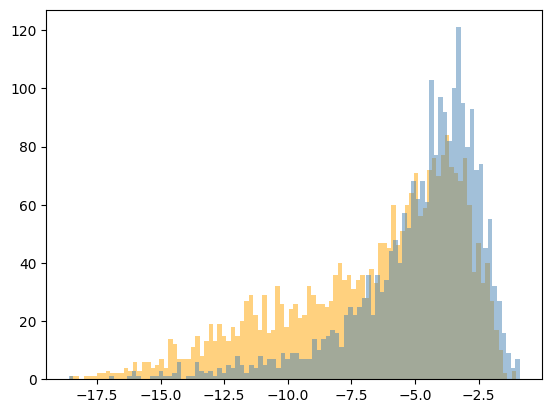

In [18]:
vis_entropy_histogram(outputs_high, y_high)

(array([434., 506., 472., 853., 537., 405., 599., 292., 583., 319.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe91601b550>])

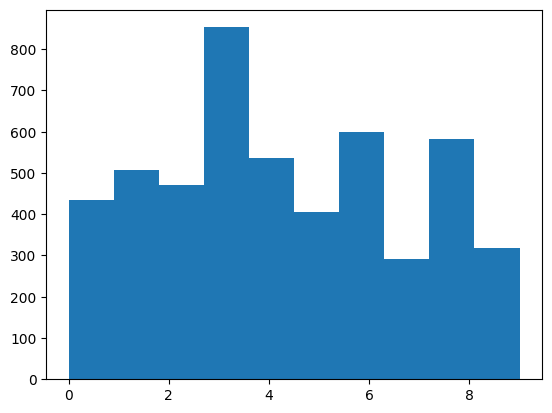

In [19]:
plt.hist(outputs_high.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')